## OPTIMIZING TRANSPILED CIRCUIT BY PERMUTING QUBITS IN A HARDWARE-ALLOWED FASHION IN QISKIT

### A) The idea ###

Given an abstract quantum circuit $C$, there are several different ways to transpile, or translate, it to a quantum circuit $C_{transpiled}$ that can actually run on a given quantum computer. In particular, given one transpiled circuit $C_{transpiled}$, we have the freedom to translate or rotate (or more generally transform) the subset of qubits of the hardware that $C_{transpiled}$ employs, $C_{transpiled} \rightarrow C'_{transpiled}$.

**Example:** A translation and a rotation of an already transpiled circuit involving only 4 of the qubits of a 9-qubit quantum computer.

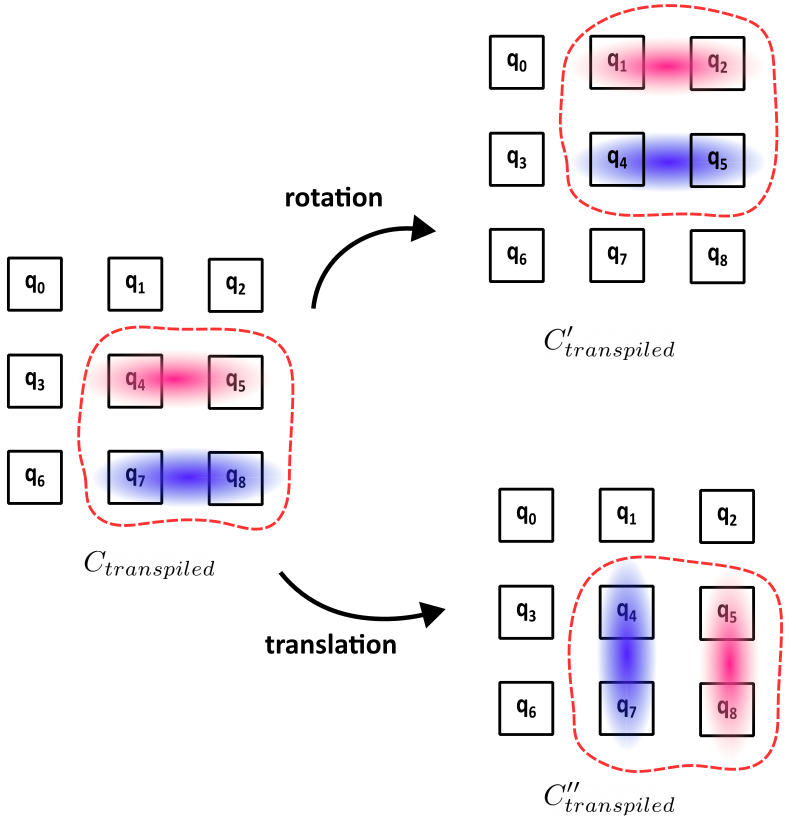

In theory, $C_{transpiled} $ and a transformed circuit $ C'_{transpiled}$ are equivalent, even if one considers typical error models. In fact, error models usually regard all (pairs of connected) qubits on the same footing. However, in practice, the set of gates involved in $C_{transpiled} $ may 'perform', e.g., prepare states, better or worse than the set of gates employed in $C'_{transpiled}$. We then propose the idea of comparing the performance of $C_{transpiled} $ and $ C'_{transpiled}$. We will measure the performance of circuits in terms of the performance of the circuit's two-qubit gates, as these are the main source of error for most quantum computers. It is thus essential to quantify the errors of the available two-qubit gates of the quantum computer one is using. Assume each pair $(i, j)$ of connected qubits, indicated with $i \sim j$, can undergo one certain two-qubit gate only (e.g., CNOT or ECR). Also, assume that the error $\epsilon_{ij}$ of each two-qubit gate is known. One can then draw a graph where each vertex $i$ represents qubit $i$; (directed) edges $(i,j)$ indicate pairs of connected qubits (going, e.g., from the control qubit to the target qubit in the case of CNOT); and the **thickness** of an edge $(i, j)$ is proportional to the error $\epsilon_{ij}$. 

**Example:** Qiskit-generated connectivity and error graph for the IBM Brisbane quantum computer.

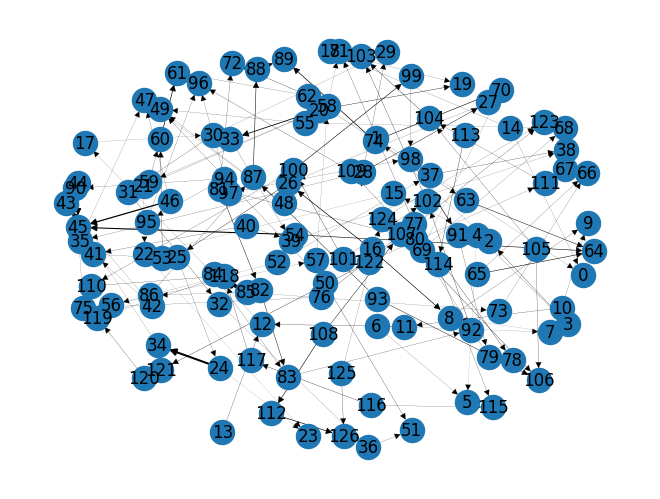

In [8]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import QiskitRuntimeService
import networkx as nx
import numpy as np

# token = # insert your token as a string, see https://quantum.ibm.com/
QiskitRuntimeService.save_account(channel='ibm_quantum', token = token, instance="ibm-q/open/main", set_as_default=True, overwrite=True)

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
#from qiskit_aer import AerSimulator
#backend = AerSimulator.from_backend(backend)
two_qubit_gate = "ecr"
conn_qubit_pairs_with_errors = [
        (
            edge[0],
            edge[1],
            backend.properties().gate_error(
                gate = two_qubit_gate, qubits=(edge[0],edge[1])
            ),
        )
        for edge in backend.coupling_map
    ]

G = nx.DiGraph()
for x in conn_qubit_pairs_with_errors:
    G.add_edge(x[0], x[1], weight=x[2])

labels = {node: str(node) for node in G.nodes()}
edges = G.edges()
width_scaling = 20.
weights = [width_scaling * G[u][v]['weight'] for u,v in edges]

nx.draw(G, labels=labels, width = weights)

## B) General features of our optimization scheme

We propose a **scheme** to optimize the performance of the transpiled circuit over these rotations and translations (and other possible allowed transformations). Our optimization scheme can be applied based on more or less detailed knowledge of the gate errors:
1. Model-specific error knowledge, based on a given quantum computer model (e.g., Brisbane);
2. Unit-specific knowledge of a certain unit of a quantum computer model (assuming many quantum computer units of the same model will be serially commercialized);
3. Unit-specific, time-resolved knowledge, based on a specific unit of a certain model at a certain moment in time.

Our scheme assumes one knows:
- the **hardware error rate** associated with any available two-qubit gate, i.e., the two-qubit connectivity and error graph;
- the **allowed rotations, translations** or more general **transformations** that can be applied to the given transpiled circuit $C_{transpiled}$ to be optimized.
We encode each of these transformations as a **permutation** $\sigma$ of all $N$ qubits of the quantum computer. We call $S_{N}^{allowed}$ the set of the $N$-element permutations $\sigma$ that correspond to allowed transformations of the circuit.

## C) The optimization scheme

Our scheme acts **after** the qiskit transpilation, allowing for seamless integration and performance enhancement without any need to rewrite qiskit code. Given a possibly already optimized qiskit-transpiled circuit $C_{transpiled}$, our scheme consists of the following **further optimization**: we minimize over all allowed permutations $\sigma \in S^{allowed}_N$ the cost function
\begin{equation}
    F(\sigma) = \sum_{i \sim j} g_{ij}(C^{\sigma}_{transpiled}) \cdot \epsilon_{ij}
\end{equation}
where
- $\sigma \in S_N^{allowed}$ is a permutation corresponding to an allowed transformation of the initial transpiled circuit $C_{transpiled}$;
- the sum is over qubits $i$ and $j$ that are connected in the hardware, denoted with $i \sim j$ ;
- $g_{ij}(C)$ is the number of two-qubit gates involving qubits $i$ and $j$ in the (already transpiled) circuit $C$;
- $C^{\sigma}_{transpiled}$ is the circuit obtained by transforming the initial circuit $C_{transpiled}$ according to $\sigma$;
- $\epsilon_{ij}$ is the error of the two-qubit (e.g., CNOT or ECR) gate, accessible in the hardware, between the connected qubits $i$ and $j$.
The optimal permutation $\sigma_{best} \in S_N^{allowed}$ that minimizes $F(\sigma)$ is then used to further improve the transpiled circuit,
\begin{equation}
    C_{transpiled} \rightarrow C'_{transpiled} = C^{\sigma_{best}}_{transpiled}.
\end{equation}

## D) Example
Consider a 6-qubit quantum computer made of a 3 x 2 grid, arranged as in the below picture.

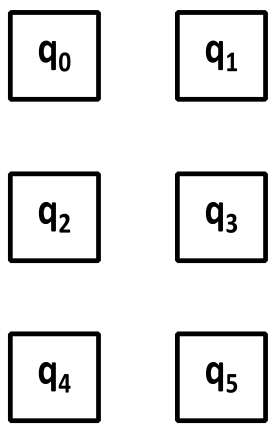

We consider a circuit that creates two Bell pairs (with H + CNOT gates) and later entangles the pairs with one more CNOT gate between the qubits that were target qubits in the first two CNOT gates.

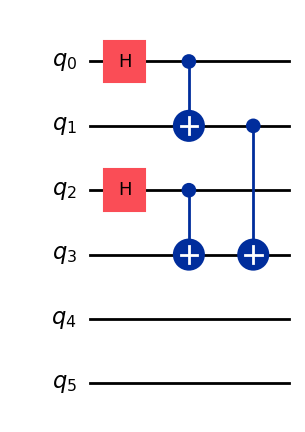

In [9]:
from qiskit import QuantumCircuit
two_bell_circuit = QuantumCircuit(6)

two_bell_circuit.h(0)
two_bell_circuit.cx(0, 1)
two_bell_circuit.h(2)
two_bell_circuit.cx(2, 3)
two_bell_circuit.cx(1, 3)
two_bell_circuit.draw('mpl')

We schematically represent the three CNOT gates of the circuit with the following intuitive picture, where **red** CNOTs are performed before the **blue** cnot:

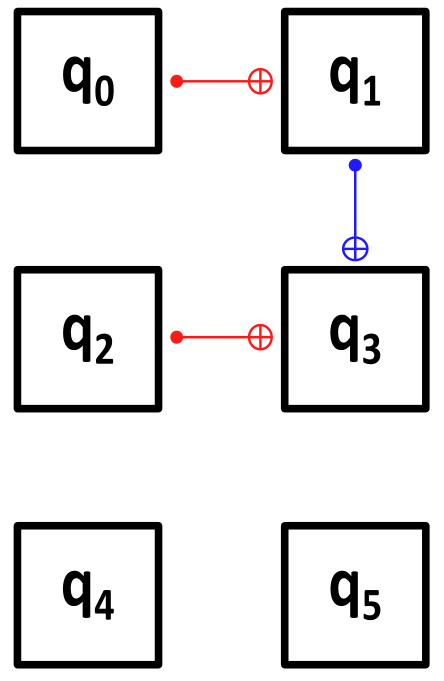


Let us assume that the available quantum computer **is able to perform CNOTs**, so that transpilation will not change the two-qubit gate content (instead, transpilation will decompose the H gates, which is however irrelevant to us). Also, assume the following hardware specifics: all and only pairs of nearest neighbor qubits can undergo a two-qubit gate, with the **lower**-index (leftmost/upper) qubit in the pair being the **control** qubit and the **higher**-index (rightmost/lower) qubit being the **target** qubit (as is the case in the above circuit!). Then, some bookkeeping shows that out of all  6! = 720 permutations $\sigma \in S_6$ of the 6 qubits there are only 5 permutations that belong to the the set $S_6^{allowed}$ of 'allowed' permutations. (This counting includes the identity permutation, and ignores the possible exchange of the two 'idle' qubits, which to be precise would double up the number of allowed permutations to 10.) By that, we mean permutations that correspond to transformations of the circuit that respect the rule set of the hardware, i.e., transformations that map the initial circuit into another circuit that can still be implemented on the hardware, i.e., the CNOTs of the transformed circuit are actually available on the hardware. The 5 corresponding circuits correspond to the following pictures. All other permutations $\sigma \in S_6$ produce a circuit containing a CNOT that cannot be performed on hardware, implying $\sigma \notin S_6^{allowed}$.

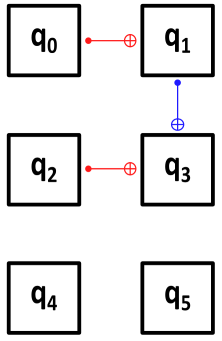    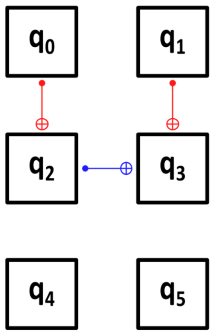 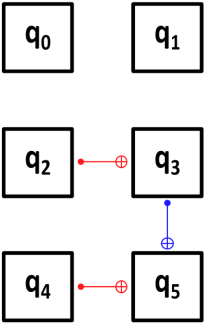 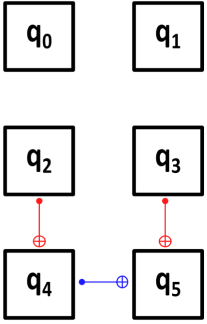 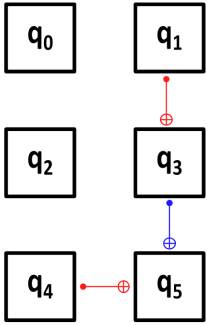

We now ask: Which of the five schematically represented circuits is the optimal? This depends on the connectivity and error graph of the quantum hardware. We assume that the graph is given by the following, where the edge list 'conn_qubit_pairs_with_errors' is made of 3-tuples $(i, j, \epsilon_{ij})$ (the third entry is the error of the two-qubit gate connecting qubits $i$ and $j$). Remember that each arrow starts from the control qubit and ends at the target qubit of the corresponding gate.

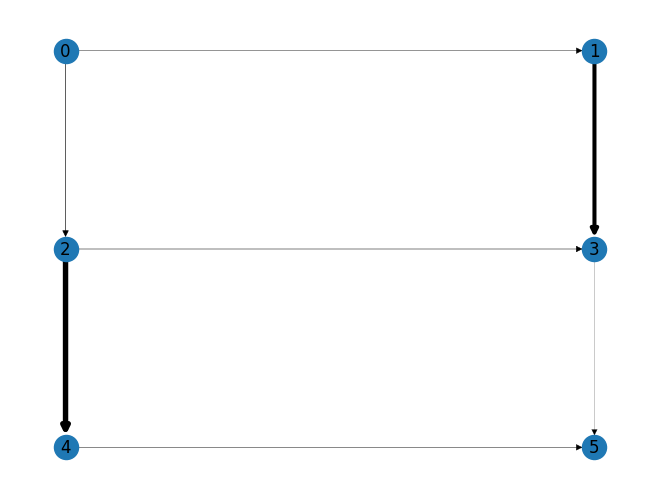

In [10]:
import networkx as nx

conn_qubit_pairs_with_errors = [
        (0,1,0.001),
        (0,2,0.0015),
        (1,3,0.0097),
        (2,3,0.0012),
        (2,4,0.013),
        (3,5,0.0005),
        (4,5,0.0011)
    ]

G = nx.DiGraph()
for x in conn_qubit_pairs_with_errors:
    G.add_edge(x[0], x[1], weight=x[2])
pos = {0: (0, 2), 1: (1, 2), 2: (0, 1), 3: (1, 1), 4:(0,0), 5:(1,0)}

labels = {node: str(node) for node in G.nodes()}
edges = G.edges()
width_scaling = 300.
weights = [width_scaling * G[u][v]['weight'] for u,v in edges]

nx.draw(G, pos, labels=labels, width = weights)


In this simple case, it is visually straightforward to see that the optimal circuit among the five ones represented above is the third one. In fact, the only problematic two-qubit gates are the qubit 1-qubit 3 gate and the qubit 2-qubit 4 gate, and among the five circuits the third one is only one which employs neither of these two faulty gates. More formally, one can consider the cost function
\begin{equation}
    F(\sigma) = \sum_{i \sim j} g_{ij}(C^{\sigma}_{transpiled}) \cdot \epsilon_{ij},
\end{equation}
defined over the five allowed permutations
\begin{align}
    \sigma_1 &= (0, 1, 2, 3, 4, 5) \\
    \sigma_2 &= (0, 2, 1, 3, 4, 5) \\
    \sigma_3 &= (2, 3, 4, 5, 0, 1) \\
    \sigma_4 &= (2, 4, 3, 5, 0, 1) \\
    \sigma_5 &= (1, 3, 4, 5, 0, 1)  \\
\end{align}
(we ignore the possible exchange of the two idle qubits). Then the point, as one can check, is that $\sigma_3$ minimizes $F(\sigma)$ over $S^{allowed}_6 = \{ \sigma_1, \sigma_2, \sigma_3, \sigma_4, \sigma_5 \}$. Recall that $g_{ij}(C^{\sigma}_{transpiled})$ is the number of two-qubit gates connecting qubits $i$ and $j$ in the $\sigma$-transformed circuit $C^{\sigma}_{transpiled}$. (Also, recall that here the transpilation prior to the application of our scheme is irrelevant because it would not change the number and position of two-qubit gates.)

## E) The general case

In general, the minimization of the cost function $F(\sigma)$ cannot be performed by simply staring at the connectivity and error graph. Instead, it can be done with a general function 'compute_optimal_perm', which we implement below, after introducing some intermediate functions. The function 'compute_optimal_perm' condenses and automatizes our proposed scheme and is thus the main result of this notebook.

More in detail, the function 'compute_optimal_perm' takes as input:
- a quantum circuit (already transpiled);
- a list that contains 3-tuples $(i,j, \epsilon_{ij})$, where $(i,j)$ represents an (ordered) pair of connected qubits and $\epsilon_{ij}$ is the unique gate the hardware can apply on them;
and it returns as output a quantum circuit that is obtained by **permuting the qubits in a way that is both optimal with respect to the given errors $\epsilon_{ij}$ and at the same time compatible with the hardware**.
See below for an application to the case of 6 qubits discussed above.

In [11]:
# Here we define the functions needed in 'compute_optimal_perm', which is implemented in the next cell

def perms(N): # returns list of permutations of (0, ..., N-1)
    import itertools
    perms = list(itertools.permutations(range(N)))
    return (perms)

def count_two_qubit_gates_between(qc, q0_index, q1_index): # returns number of two-qubit gates between q0 and q1 in circuit qc
    q0, q1 = qc.qubits[q0_index], qc.qubits[q1_index]
    target_pair = {q0, q1}
    count = 0
    for instr, qargs, _ in qc.data:
        if len(qargs) == 2 and set(qargs) == target_pair:
            count += 1
    return count

def permute_qubits(qc, sigma):
    N = len(sigma)
    assert qc.num_qubits == N, "Permutation size must match number of qubits"

    # Compute the inverse permutation: maps new index to old index
    inverse_sigma = [0] * N
    for i, j in enumerate(sigma):
        inverse_sigma[j] = i

    qc_perm = QuantumCircuit(N, qc.num_clbits)

    for instr, qargs, cargs in qc.data:
        # Use qubits.index(q) to get the index
        new_qargs = [qc_perm.qubits[inverse_sigma[qc.qubits.index(q)]] for q in qargs]
        new_cargs = [qc_perm.clbits[qc.clbits.index(c)] for c in cargs]
        qc_perm.append(instr, new_qargs, new_cargs)

    return qc_perm

def cost_function(count_gates, conn_qubit_pairs_with_errors):
    F = 0.
    for pair_and_err in conn_qubit_pairs_with_errors:
        i  = pair_and_err[0]
        j  = pair_and_err[1]
        err = pair_and_err[2]
        for x in count_gates:
            if (x[0] == i and x[1] == j ) or (x[1] == i and x[0] == j ):
                count = x[2]
                F += count * err
    return F


In [12]:
def compute_optimal_perm(qc, conn_qubit_pairs_with_errors):
    """
    INPUT:
    qc(QuantumCircuit): a (previously transpiled) quantum circuit qc. should already satisfy the hardware requirements
    conn_qubit_pairs_with_errors(List[Tuple[int, int, float]]): a list of 3-tuples (i, j, err). this list is a directed graph containing information on the hardware-available two-qubit gates and their error rates as edge widths. For each 3-tuple (i, j, err), (i,j) is an ordered couple that can undergo a two-qubit gate, with error err
    OUTPUT:
    qc_sigma_best(QuantumCircuit): the optimized circuit, transformed based on the best hardware-allowed permutation sigma_best that minimizes the cost function

    """
    connected_pairs = []
    for x in conn_qubit_pairs_with_errors:
        connected_pairs.append((x[0], x[1]))
        connected_pairs.append((x[1], x[0]))
    N = qc.num_qubits
    sigmas = perms(N)
    count_gates = []
    for i in range(N - 1):
        for j in range(i + 1, N):
            count_gates.append( (i, j, count_two_qubit_gates_between(qc, i, j)) )
    F_min = float('inf')
    sigma_min = sigmas[0] #identity permutation
    for sigma in sigmas:
        perm_count_gates = []
        for x in count_gates:
            perm_count_gates.append((sigma[x[0]], sigma[x[1]], x[2]))
        is_valid_perm = True # check whether permutation is allowed by hardware!
        for x in perm_count_gates: 
            if x[2] != 0 and ( (x[0], x[1]) not in connected_pairs):
                is_valid_perm = False
        if is_valid_perm == True:
            F = cost_function(perm_count_gates, conn_qubit_pairs_with_errors)
        if F < F_min:
            F_min = F
            sigma_min = sigma
        qc_perm = permute_qubits(qc, np.argsort(sigma_min)) # make sure you dont have to invert permutation! i dont think so
    return(qc_perm)


## F) Application to 6-qubit circuit

We now apply the general function introduced above to the case of 6 qubits that we treated on an intuitive level before. The result agrees with the intuitive solution, i.e., the optimal and hardware-allowed permutation of the qubits is indeed $\sigma_3 = (2, 3, 4, 5, 0, 1)$. In other words, as expected, the underlying numerical minimization of the cost function confirms that the optimal permutation is the only one that is both allowed by the hardware, and allows us to avoid using the two 'faulty' two-qubit gates. Here is the resulting optimized circuit $C^{\sigma_{best}}_{transpiled}$:

C:\Users\doubl\AppData\Local\Temp\ipykernel_3068\4096437175.py:12: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in qc.data:
C:\Users\doubl\AppData\Local\Temp\ipykernel_3068\4096437175.py:28: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data:


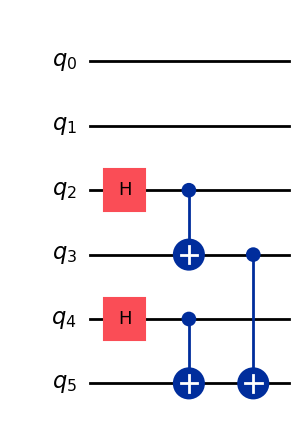

In [13]:
two_bell_circuit_optimal_perm = compute_optimal_perm(two_bell_circuit, conn_qubit_pairs_with_errors)
two_bell_circuit_optimal_perm.draw('mpl')

This circuit indeed corresponds to the circuit representation relative to $\sigma_3$, which we copy here for clarity. (Recall that blue CNOTs are applied after red CNOTs.)


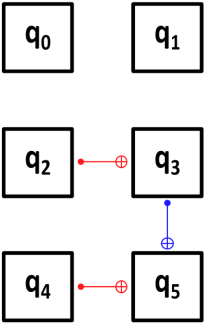
